In [1]:
import os
import sys
import importlib
from pathlib import Path

mod = sys.modules[__name__]

code_dir = None
code_dir_name = 'Code'
unwanted_subdir_name = 'Analysis'

for _ in range(5):

    parent_path = str(Path.cwd().parents[_]).split('/')[-1]

    if (code_dir_name in parent_path) and (unwanted_subdir_name not in parent_path):

        code_dir = str(Path.cwd().parents[_])

        if code_dir is not None:
            break

# %load_ext autoreload
# %autoreload 2


In [2]:
# MAIN DIR
main_dir = f'{str(Path(code_dir).parents[0])}/'

# code_dir
code_dir = f'{code_dir}/'
sys.path.append(code_dir)

# scraping dir
scraped_data = f'{code_dir}scraped_data/'

# data dir
data_dir = f'{code_dir}data/'

# df save sir
df_save_dir = f'{data_dir}final dfs/'

# lang models dir
llm_path = f'{data_dir}Language Models'

# models dir
models_save_path = f'{data_dir}classification models/'

# output tables dir
table_save_path = f'{data_dir}output tables/'

# plots dir
plot_save_path = f'{data_dir}plots/'

In [3]:
import string
import re
import time
import timeit
import tqdm
import json
import csv
import glob
import pickle
import joblib
import random
import itertools
import unicodedata
import contextlib
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns


In [4]:
# ML imports
import sklearn
from sklearn import feature_selection, metrics, set_config, svm, utils
from sklearn.utils import (check_consistent_length, check_random_state, check_X_y, parallel_backend)
from sklearn.utils.validation import (check_is_fitted, column_or_1d,
                                      has_fit_parameter)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.feature_selection import (SelectFdr, SelectFpr,
                                       SelectFromModel, SelectFwe,
                                       SelectKBest, SelectPercentile, chi2,
                                       f_classif, f_regression,
                                       mutual_info_classif,
                                       mutual_info_regression)
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.linear_model import (LogisticRegression,
                                  PassiveAggressiveClassifier, Perceptron,
                                  SGDClassifier)
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier,
                              BaggingRegressor, ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier, StackingClassifier,
                              StackingRegressor, VotingClassifier,
                              VotingRegressor)
from sklearn.model_selection import (GridSearchCV, KFold, LeaveOneOut,
                                     RandomizedSearchCV,
                                     RepeatedStratifiedKFold, ShuffleSplit,
                                     StratifiedKFold,
                                     StratifiedShuffleSplit,
                                     cross_val_score, cross_val_predict, cross_validate,
                                     learning_curve, train_test_split)
from sklearn.metrics import (ConfusionMatrixDisplay,accuracy_score, balanced_accuracy_score,
                             brier_score_loss, classification_report, cohen_kappa_score,
                             confusion_matrix, f1_score, log_loss,
                             make_scorer, matthews_corrcoef, fowlkes_mallows_score,
                             precision_recall_curve, precision_score,
                             recall_score, roc_auc_score)
from sklearn.calibration import CalibrationDisplay
from scipy.special import softmax
import imblearn
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler
from imblearn.under_sampling import (EditedNearestNeighbours, NearMiss,
                                     RandomUnderSampler, TomekLinks)
from xgboost import XGBClassifier
import plot_metric
from plot_metric.functions import BinaryClassification
import torch
import torch.nn.functional as F

# Set up Bert
import torch
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification, TokenClassificationPipeline,
    BertTokenizer, BertTokenizerFast, BertForSequenceClassification, Trainer, TrainingArguments,
    DistilBertTokenizerFast, DistilBertForSequenceClassification, BertForPreTraining, BertConfig, BertModel
)
random_state = 42
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)
max_length = 512
cpu_counts = torch.multiprocessing.cpu_count()
device = torch.device('mps') if torch.has_mps and torch.backends.mps.is_available() and torch.backends.mps.is_built() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device_name = str(device.type)
print(f'Using {device_name.upper()}')

bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizerFast.from_pretrained(bert_model_name, strip_accents = True)
bert_model = BertForSequenceClassification.from_pretrained(bert_model_name).to(device)


Using MPS


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### READ DATA

In [5]:
# Variables
plt.style.use('tableau-colorblind10')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 5000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', '{:.3f}'.format)

random_state = 42
random.seed(random_state)
np.random.seed(random_state)
max_length = 512
torch.manual_seed(random_state)
method = 'BERT'
n_jobs = -1
cv = RepeatedStratifiedKFold(
    n_splits=10, n_repeats=3, random_state=random_state)
t = time.time()
cores = multiprocessing.cpu_count()
scoring = 'recall'
scores = ['recall', 'accuracy', 'f1', 'roc_auc', 'explained_variance', 'matthews_corrcoef']
scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
}
analysis_columns = ['Warmth', 'Competence']
text_col = 'Job Description spacy_sentencized'


In [6]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, encoded):
        self.encodings = encodings
        self.encoded = encoded

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx], device=device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.encoded[idx], device=device)
        return item

    def __len__(self):
        return len(self.encoded)


In [7]:
def split_data(df, col, analysis_columns, text_col=None):

    if text_col is None:
        text_col = 'Job Description spacy_sentencized'

    train_ratio = 0.75
    test_ratio = 0.10
    validation_ratio = 0.15
    test_split = test_size = 1 - train_ratio
    validation_split = test_ratio / (test_ratio + validation_ratio)

    # Split
    print('='*20)
    print('Splitting data into training, testing, and validation sets:')
    print(f'Ratios: train_size = {train_ratio}, test size = {test_ratio}, validation size = {validation_ratio}')

    df.dropna(subset=analysis_columns, how='any', inplace=True)
    df.reset_index(drop=True, inplace=True)

    train, test = train_test_split(
        df, train_size = 1-test_split, test_size = test_split, random_state=random_state
    )

    val, test = train_test_split(
        test, test_size=validation_split, random_state=random_state
    )

    X_train = np.array(list(train[text_col].astype('str').values))
    y_train = column_or_1d(train[col].astype('int64').values.tolist(), warn=True)

    X_test = np.array(list(test[text_col].astype('str').values))
    y_test = column_or_1d(test[col].astype('int64').values.tolist(), warn=True)

    X_val = np.array(list(val[text_col].astype('str').values))
    y_val = column_or_1d(val[col].astype('int64').values.tolist(), warn=True)

    class_weights = compute_class_weight(class_weight = 'balanced', classes = [0,1], y = y_train)
    class_weights_ratio = class_weights[0]/class_weights[1]
    class_weights_dict = dict(zip(np.unique(y_train), class_weights))

    print('Done splitting data into training, testing, and validation sets.')

    return (
        train, X_train, y_train,
        test, X_test, y_test,
        val, X_val, y_val,
        class_weights,
        class_weights_ratio,
        class_weights_dict
    )


In [8]:
def encode_data(df, col, analysis_columns, text_col=None):

    # Split
    (
        train, X_train, y_train,
        test, X_test, y_test,
        val, X_val, y_val,
        class_weights,
        class_weights_ratio,
        class_weights_dict
    ) = split_data(
        df=df_manual, col=col, analysis_columns=analysis_columns, text_col=text_col
    )

    if text_col is None:
        text_col = 'Job Description spacy_sentencized'

    print('='*20)
    print(
        'Encoding training, testing, and validation sets with BertTokenizerFast.from_pretrained'
    )

    bert_label2id = {label: id_ for id_, label in enumerate(set(label for label in y_train))}
    bert_id2label = {id_: label for label, id_ in bert_label2id.items()}

    X_train_bert_encodings = bert_tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='pt').to(device)
    y_train_bert_encoded = [bert_label2id[y] for y in y_train]
    bert_train_dataset = MyDataset(X_train_bert_encodings, y_train_bert_encoded)

    X_test_bert_encodings = bert_tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='pt').to(device)
    y_test_bert_encoded = [bert_label2id[y] for y in y_test]
    bert_test_dataset = MyDataset(X_test_bert_encodings, y_test_bert_encoded)

    X_val_bert_encodings = bert_tokenizer(X_val.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='pt').to(device)
    y_val_bert_encoded = [bert_label2id[y] for y in y_val]
    bert_val_dataset = MyDataset(X_val_bert_encodings, y_val_bert_encoded)

    print('Done encoding training, testing, and validation sets.')
    print('='*20)
    print(f'Training set shape: {y_train.shape}')
    print('-'*10)
    print(f'Training set example:\n{X_train[0]}')
    print('-'*10)
    print(f'Training set BERT encodings example:\n{" ".join(bert_train_dataset.encodings[0].tokens[:30])}')
    print('-'*10)
    print(f'Training labels after BERT encoding: {set(y_train_bert_encoded)}')
    print('~'*10)
    print(f'Testing set shape: {y_test.shape}')
    print('-'*10)
    print(f'Testing set example:\n{X_test[0]}')
    print('-'*10)
    print(f'Testing set BERT encodings example:\n{" ".join(bert_test_dataset.encodings[0].tokens[:30])}')
    print('-'*10)
    print(f'Testing labels after BERT encoding: {set(y_test_bert_encoded)}')
    print('~'*10)
    print(f'Validation set shape: {y_val.shape}')
    print('-'*10)
    print(f'Validation set example:\n{X_val[0]}')
    print('-'*10)
    print(f'Validation set BERT encodings example:\n{" ".join(bert_val_dataset.encodings[0].tokens[:30])}')
    print('-'*10)
    print(f'Validation labels after BERT encoding: {set(y_val_bert_encoded)}')
    print('~'*10)
    print(f'Class weights:\nRatio = {class_weights_ratio:.2f} (0 = {class_weights[0]:.2f}, 1 = {class_weights[1]:.2f})')
    print('='*20)

    return (
        train, X_train, X_train_bert_encodings, y_train, y_train_bert_encoded, bert_train_dataset,
        test, X_test, X_test_bert_encodings, y_test, y_test_bert_encoded, bert_test_dataset,
        val, X_val, X_val_bert_encodings, y_val, y_val_bert_encoded, bert_val_dataset,
        bert_label2id, bert_id2label, class_weights, class_weights_ratio, class_weights_dict
    )


In [9]:
def plot_metrics(cm_curve, cm_normalized_curve, roc_curve, pr_curve, calibration_curve, col, vectorizer_name, classifier_name):

    # Plots
    print('=' * 20)
    plt.clf()
    plt.cla()
    plt.close()
    print('Plotting:')

    ## Confusion Matrix
    print('-' * 20)
    print('Confusion Matrix:')
    fig, ax = plt.subplots()
    ax.set_title(f'Confusion Matrix {str(col)} - {vectorizer_name} + {classifier_name}')
    cm_curve.plot(ax=ax)
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

    ## Normalized Confusion Matrix
    print('-' * 20)
    print('Normalized Confusion Matrix:')
    fig, ax = plt.subplots()
    ax.set_title(f'Normalized Confusion Matrix {str(col)} - {vectorizer_name} + {classifier_name}')
    cm_normalized_curve.plot(ax=ax)
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

    ## ROC Curve
    print('-' * 20)
    print('ROC Curve:')
    fig, ax = plt.subplots()
    ax.set_title(f'ROC Curve {str(col)} - {vectorizer_name} + {classifier_name}')
    roc_curve.plot(ax=ax)
    ax.plot([0, 1], [0, 1],'r--', lw=1)
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

    ## PR Curve
    print('-' * 20)
    print('Precision Recall Curve:')
    fig, ax = plt.subplots()
    ax.set_title(f'Precision-Recall Curve {str(col)} - {vectorizer_name} + {classifier_name}')
    pr_curve.plot(ax=ax)
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

    ## Calibration Curve
    print('-' * 20)
    print('Calibration Curve:')
    fig, ax = plt.subplots()
    ax.set_title(f'Calibration Curve {str(col)} - {vectorizer_name} + {classifier_name}')
    calibration_curve.plot(ax=ax)
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    print('=' * 20)

    # Save Plots
    print('Saving plots...')
    for image_save_format in ['eps', 'png']:
        cm_curve.figure_.savefig(
            f'{plot_save_path}{method} Confusion Matrix {str(col)} - {vectorizer_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        cm_normalized_curve.figure_.savefig(
            f'{plot_save_path}{method} Normalized Confusion Matrix {str(col)} - {vectorizer_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        roc_curve.figure_.savefig(
            f'{plot_save_path}{method} ROC Curve {str(col)} - {vectorizer_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        pr_curve.figure_.savefig(
            f'{plot_save_path}{method} Precision Recall Curve {str(col)} - {vectorizer_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        calibration_curve.figure_.savefig(
            f'{plot_save_path}{method} Calibration Curve {str(col)} - {vectorizer_name} + {classifier_name}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )



In [10]:
def compute_metrics(predicted_results):

    # Get y_test_pred
    y_test = predicted_results.label_ids
    y_test_pred = predicted_results.predictions.argmax(-1)
    y_test_pred = y_test_pred.flatten().tolist()
    y_test_pred = [bert_label2id[l] for l in y_test_pred]

    # # Get y_test_pred_proba
    # try:
    #     y_test_pred_proba = torch.nn.functional.softmax(predicted_results, dim=-1)
    #     print('Using torch.nn.functional.softmax')
    # except Exception:
    #     y_test_pred_proba = softmax(predicted_results, axis=1)
    #     print('Using scipy.special.softmax')
    # finally:
    #     y_test_pred_proba = y_test_pred_proba.flatten().tolist()

    # # Get metrics
    # # Using estimator
    # cross_validate_score_noscoring = cross_validate(
    #     estimator,
    #     X_test,
    #     y_test,
    #     cv=cv,
    #     return_train_score=True,
    # )
    # cross_validate_score = cross_validate(
    #     estimator,
    #     X_test,
    #     y_test,
    #     cv=cv,
    #     return_train_score=True,
    #     scoring=scores,
    # )
    # mean_validation_score = cross_validate_score_noscoring.get('test_score').mean()
    # explained_variance = cross_validate_score.get('test_explained_variance').mean()

    # Using y_pred
    accuracy = metrics.accuracy_score(y_test, y_test_pred)
    balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_test_pred)
    precision = metrics.precision_score(y_test, y_test_pred, pos_label=1, labels=[1, 0])
    recall = metrics.recall_score(y_test, y_test_pred, pos_label=1, labels=[1, 0])
    f1 = metrics.f1_score(y_test, y_test_pred)
    mcc = metrics.matthews_corrcoef(y_test, y_test_pred)
    fm = metrics.fowlkes_mallows_score(y_test, y_test_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_test_pred)
    gmean_iba = imblearn.metrics.make_index_balanced_accuracy(alpha=0.1, squared=True)(geometric_mean_score)
    gmean = gmean_iba(y_test, y_test_pred)
    report = metrics.classification_report(y_test, y_test_pred)
    cm = metrics.confusion_matrix(y_test, y_test_pred)
    cm_normalized = metrics.confusion_matrix(y_test, y_test_pred, normalize='true')

    # Matrices from Display
    cm_curve = metrics.ConfusionMatrixDisplay.from_predictions(
        y_test, y_test_pred
    )
    cm_normalized_curve = metrics.ConfusionMatrixDisplay.from_predictions(
        y_test, y_test_pred, normalize='true'
    )
    roc_curve = metrics.RocCurveDisplay.from_predictions(
        y_test, y_test_pred, pos_label=1
    )
    pr_curve = metrics.PrecisionRecallDisplay.from_predictions(
        y_test, y_test_pred, pos_label=1
    )
    calibration_curve = CalibrationDisplay.from_predictions(
        y_test, y_test_pred, pos_label=1### ADD NAME LATER
    )

    #Place metrics into dict
    metrics_dict = {
        'Mean Validation Score': float(mean_validation_score),
        'Explained Variance': float(explained_variance),
        'Accuracy': float(accuracy),
        'Balanced Accuracy': float(balanced_accuracy),
        'Precision': float(precision),
        'Recall': float(recall),
        'F1-score': float(f1),
        'Matthews Correlation Coefficient': float(mcc),
        'Fowlkes–Mallows Index': float(fm),
        'ROC': float(roc_auc),
        'AUC': float(auc),
        f'{scoring.title()} Best Threshold': float(threshold),
        'Log Loss/Cross Entropy': float(loss),
        'Cohen’s Kappa': float(kappa),
        'Geometric Mean': float(gmean),
        'Classification Report': report,
        'Confusion Matrix': cm,
        'Normalized Confusion Matrix': cm_normalized
    }

    # Visualisation with plot_metric
    bc = plot_metric.functions.BinaryClassification(y_test, y_test_pred, labels=[0, 1])

    # Figures
    plt.figure(figsize=(15,10))
    plt.subplot2grid((2,6), (1,1), colspan=2)
    bc.plot_confusion_matrix(colorbar=True)
    plt.subplot2grid((2,6), (1,3), colspan=2)
    bc.plot_confusion_matrix(normalize=True, colorbar=True)
    plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
    bc.plot_roc_curve()
    plt.subplot2grid((2,6), (0,2), colspan=2)
    bc.plot_precision_recall_curve()
    plt.subplot2grid((2,6), (0,4), colspan=2)
    bc.plot_class_distribution()
    plt.show()
    bc.print_report()

    return metrics_dict

In [11]:
def evaluation(metrics_dict, df_metrics, col, classifier_name, tokenizer_name):

    
    # Print metrics
    print('=' * 20)
    print('~' * 20)
    print(' Metrics:')
    print('~' * 20)
    print(f'Classification Report:\n {metrics_dict["Classification Report"]}')
    print('-' * 20)
    for test_metric_name, metric_value in metrics_dict.items():
        if test_metric_name not in ['test_runtime', 'test_samples_per_second', 'test_steps_per_second']:
            metric_name = test_metric_name.split("test_")[1].title()
            print(f'{metric_name}: {metric_value}')
            print('-' * 20)

            # Fill Table DF
            if isinstance(metric_value, float):
                df_metrics.loc[
                    (classifier_name), (col, tokenizer_name, metric_name)
                ] = float(metric_value)
            else:
                df_metrics.loc[
                    (classifier_name), (col, tokenizer_name, metric_name)
                ] = str(metric_value)

    print('=' * 20)

    # Plot Metrics
    plot_metrics(
        cm_curve, cm_normalized_curve, roc_curve, pr_curve, calibration_curve, col, tokenizer_name, classifier_name
    )

    return df_metrics


In [12]:
# Save Model
def saving_model_and_table(col, df_metrics, estimator, tokenizer_name, classifier_name):

    # Save metrics df
    print(f'Saving Model and Table for {tokenizer_name} + {classifier_name}.')
    df_metrics.to_csv(f'{table_save_path}Classifiers Table.csv')
    df_metrics.to_pickle(f'{table_save_path}Classifiers Table.pkl')
    df_metrics.to_excel(f'{table_save_path}Classifiers Table.xlsx')
    df_metrics.to_latex(f'{table_save_path}Classifiers Table.tex')
    df_metrics.to_markdown(f'{table_save_path}Classifiers Table.md')

    # Save estimator
    estimator.save_model(f'{models_save_path}{method} Estimator {str(col)} - {tokenizer_name} + {classifier_name})')


In [13]:
# Save Model
def get_fitted_estimators():
    
    estimators_list = []

    for model_path in glob.glob(f'{models_save_path}*.pkl'):
        with open(model_path, 'rb') as f:
            estimators_list.append(joblib.load(f))

    return estimators_list


In [14]:
def comparison_plots(estimators_list, X_test, y_test, col):

    assert len(estimators_list) != 0

    print('=' * 20)
    ## ROC Curve
    print('-' * 20)
    print(f'ROC Curve: {str(col)}')
    fig, ax = plt.subplots()
    ax.set_title(f'ROC Curve: {str(col)}')
    for estimator in estimators_list:
        roc_curve = metrics.RocCurveDisplay.from_estimator(
            estimator, X_test, y_test, pos_label=1, ax=ax, name=f'{estimator.steps[0][0]} + {estimator.steps[1][0]} + {estimator.steps[-1][0]}'
        )
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

    ## PR Curve
    print('-' * 20)
    print(f'Precision Recall Curve: {str(col)}')
    fig, ax = plt.subplots()
    ax.set_title(f'Precision Recall Curve: {str(col)}')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    for estimator in estimators_list:
        pr_curve = metrics.PrecisionRecallDisplay.from_estimator(
            estimator, X_test, y_test, pos_label=1, ax=ax, name=f'{estimator.steps[0][0]} + {estimator.steps[1][0]} + {estimator.steps[-1][0]}'
        )
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

    ## Calibration Curve
    print('-' * 20)
    print(f'Calibration Curve: {str(col)}')
    fig, ax = plt.subplots()
    ax.set_title(f'Calibration Curve: {str(col)}')
    for estimator in estimators_list:
        calibration_curve = CalibrationDisplay.from_estimator(
            estimator, X_test, y_test, pos_label=1, ax=ax, name=f'{estimator.steps[0][0]} + {estimator.steps[1][0]} + {estimator.steps[-1][0]}'
        )
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()
    print('=' * 20)

    # Save Plots
    print('Saving plots.')
    for image_save_format in ['eps', 'png']:
        roc_curve.figure_.savefig(
            f'{plot_save_path}{method} All ROC Curve {str(col)}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        pr_curve.figure_.savefig(
            f'{plot_save_path}{method} All Precision Recall Curve {str(col)}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )

        calibration_curve.figure_.savefig(
            f'{plot_save_path}{method} All Calibration Curve {str(col)}.{image_save_format}',
            format=image_save_format,
            dpi=3000, bbox_inches='tight'
        )


### READ DATA

In [15]:
df_manual = pd.read_pickle(f'{df_save_dir}df_manual_for_trainning.pkl').reset_index(drop=True)
# REMOVE THIS!!!!!!
df_manual = df_manual.groupby(analysis_columns).sample(n=200).reset_index(drop = True)
# def compute_metrics(pred):
#   labels = pred.label_ids
#   preds = pred.predictions.argmax(-1)
#   accuracy = metrics.accuracy_score(labels, preds)
#   recall = metrics.recall_score(labels, preds)
#   return {
#       'accuracy': accuracy,
#       'recall': recall
#   }

########################################
Starting!
########################################
--------------------
============================== TRAINING WARMTH ==============================
--------------------
Splitting data into training, testing, and validation sets:
Ratios: train_size = 0.75, test size = 0.1, validation size = 0.15
Done splitting data into training, testing, and validation sets.
Encoding training, testing, and validation sets with BertTokenizerFast.from_pretrained
Done encoding training, testing, and validation sets.
Training set shape: (600,)
----------
Training set example:
Excellent analytical skills with the ability to synthesise complex information and identify key issues, concerns or trends;
----------
Training set BERT encodings example:
[CLS] excellent analytical skills with the ability to synthesis ##e complex information and identify key issues , concerns or trends ; [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
----------
Training labels after B

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Initializing BERT Model using BertTokenizerFast + BertForSequenceClassification for Warmth
Passing arguments to estimator.
Starting training for Warmth
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/114 [00:00<?, ?it/s]

/var/folders/46/q15p556n1dd63z6gkwyh896c0000gn/T/ipykernel_46717/1230619439.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx], device=device) for key, val in self.encodings.items()}


{'loss': 0.5522, 'learning_rate': 5e-05, 'epoch': 2.63}


  0%|          | 0/4 [00:00<?, ?it/s]

NameError: name 'vectorizer_name' is not defined

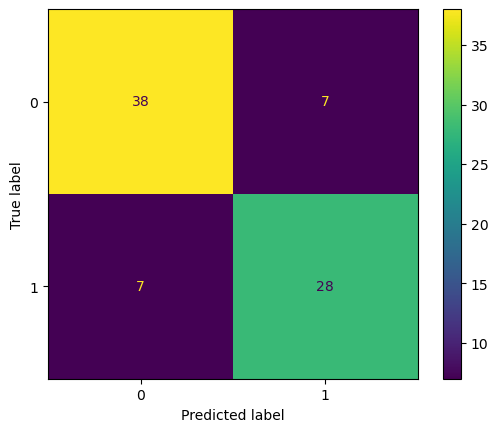

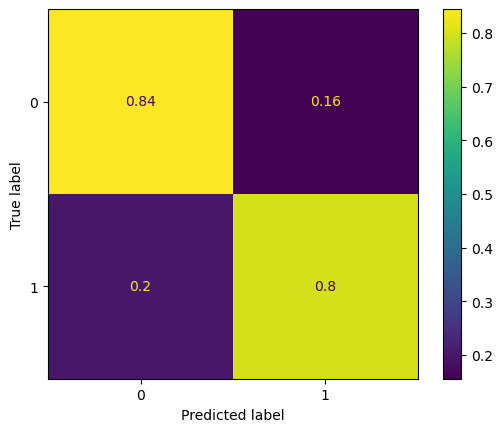

In [16]:
%%time
print('#'*40)
print('Starting!')
print('#'*40)

analysis_columns = ['Warmth', 'Competence']
text_col = 'Job Description spacy_sentencized'

# Load Table DF
df_metrics = pd.read_pickle(f'{table_save_path}Classifiers Table.pkl')

for col in analysis_columns:

    print('-'*20)
    print(f'{"="*30} TRAINING {col.upper()} {"="*30}')
    print('-'*20)

    assert len(df_manual[df_manual[str(col)].map(df_manual[str(col)].value_counts() > 1)]) != 0

    # Split
    (
        train, X_train, X_train_bert_encodings, y_train, y_train_bert_encoded, bert_train_dataset,
        test, X_test, X_test_bert_encodings, y_test, y_test_bert_encoded, bert_test_dataset,
        val, X_val, X_val_bert_encodings, y_val, y_val_bert_encoded, bert_val_dataset,
        bert_label2id, bert_id2label, class_weights, class_weights_ratio, class_weights_dict
    ) = encode_data(
        df=df_manual, col=col, analysis_columns=analysis_columns, text_col=text_col
    )

    # Initialize Model
    random_state = 42
    random.seed(random_state)
    np.random.seed(random_state)
    max_length = 512
    device = torch.device('mps') if torch.has_mps else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    bert_model_name = 'bert-base-uncased'
    
    # Load pre-trained BERT model
    bert_model = BertForSequenceClassification.from_pretrained(
        bert_model_name, num_labels=len(bert_id2label)
    ).to(device)

    # Name tokenizer and classifier name
    tokenizer_name = bert_tokenizer.__class__.__name__
    classifier_name = bert_model.__class__.__name__

    print(f'Initializing BERT Model using {tokenizer_name} + {classifier_name} for {col}')

    # Set BERT fine-tuning parameters
    bert_training_args = TrainingArguments(
        output_dir=f'{models_save_path}{method} Results',
        logging_dir=f'{models_save_path}{method} Logs',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=20,
        learning_rate=5e-5,
        warmup_steps=100,
        weight_decay=0.01,
        logging_steps=100,
        evaluation_strategy='steps',
        optim='adamw_torch',
        use_mps_device=True if device.type == 'mps' else False
    )

    # Pass data to trainer 
    print('Passing arguments to estimator.')
    estimator = Trainer(
        model=bert_model,
        args=bert_training_args,
        optimizer=bert_optimizer,
        train_dataset=bert_train_dataset,
        eval_dataset=bert_test_dataset,
        compute_metrics=compute_metrics
    )

    # Train trainer
    print(f'Starting training for {col}')
    estimator.train()
    estimator.save_model(f'{models_save_path}{method} Estimator {str(col)} - {tokenizer_name} + {classifier_name})')
    print('Done training!')

    # Get predictions
    print(f'Evaluating estimator for {col}')
    estimator.evaluate()
    # metrics_dict
    predicted_results = estimator.predict(bert_val_dataset)
    print(f'Predictions shape for {col}: {predicted_results.predictions.shape}')
    
    # Get y_test_pred
    y_test = predicted_results.label_ids
    y_test_pred = predicted_results.predictions.argmax(-1)
    y_test_pred = y_test_pred.flatten().tolist()
    y_test_pred = [bert_label2id[l] for l in y_test_pred]
    print(f'Length of y_test_pred: {len(y_test_pred)}')

    # Get y_test_pred_proba
    y_test_pred_proba = torch.nn.functional.softmax(predicted_results, dim=-1)
    y_test_pred_proba = y_test_pred_proba.flatten().tolist()
    print(f'Length of y_test_pred_proba: {len(y_test_pred_proba)}')
    
    # Evluate estimator
    df_metrics = evaluation(predicted_results, df_metrics, col, classifier_name, tokenizer_name)

    # Save BERT Model
    print(f'Saving estimator and metrics table for {col}')
    saving_model_and_table(df_metrics, estimator, col, tokenizer_name, classifier_name)

    # Compare Estimators
    print('='*20)
    print(f'Comparing estimators for {col}')
    comparison_plots(get_fitted_estimators().append(estimator), X_test, y_test, col)
    print('='*20)

print('#'*40)
print('DONE!')
print('#'*40)

